In [1]:
import pandas as pd
import numpy as np
from scipy.ndimage.interpolation import shift

import matplotlib.pyplot as plt

import keras
from keras.models import Model
from keras.layers import GaussianNoise, LSTM, Dense, Dropout, Input, Concatenate, TimeDistributed

from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
path = "/content/drive/My Drive/SaicAILab"
os.chdir(path)

### 读入数据

In [4]:
cols = [
    'spd', 'vsb', 'temp', 'dewp', 'slp', 'pcp01', 'pcp06', 'pcp24', 'sd',
    'hday', 'pickups'
]
data = pd.read_csv('uber_data.csv',
                   parse_dates=['pickup_dt'],
                   index_col='pickup_dt')
data = pd.DataFrame(data, columns=cols)
data.head(30)
#风速，可见度，温度，露点温度，海平面压力，1小时内降水量，6小时降水量，24小时降水量，降雪深度，是否节假日，订单数量

,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday,pickups
pickup_dt,,,,,,,,,,,
2015-01-01 01:00:00,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,1,7344
2015-01-01 02:00:00,3.0,10.0,30.0,6.0,1023.0,0.0,0.0,0.0,0.0,1,6043
2015-01-01 03:00:00,5.0,10.0,30.0,8.0,1022.3,0.0,0.0,0.0,0.0,1,6763
2015-01-01 04:00:00,5.0,10.0,29.0,9.0,1022.0,0.0,0.0,0.0,0.0,1,4872
2015-01-01 05:00:00,5.0,10.0,28.0,9.0,1021.8,0.0,0.0,0.0,0.0,1,2406
2015-01-01 06:00:00,10.0,10.0,28.0,8.0,1020.7,0.0,0.0,0.0,0.0,1,1342
2015-01-01 07:00:00,9.0,10.0,28.0,10.0,1020.5,0.0,0.0,0.0,0.0,1,821
2015-01-01 08:00:00,7.0,10.0,27.0,9.0,1020.5,0.0,0.0,0.0,0.0,1,580
2015-01-01 09:00:00,3.0,10.0,27.0,7.0,1020.0,0.0,0.0,0.0,0.0,1,565


In [5]:
def log10p(x):
  return np.log10(100+x)

#数据预处理
def data_preprocessing(method):
    if method == 'MinMax':
        scaler = MinMaxScaler(feature_range=(0,1))
    elif method == 'log10':
        scaler = FunctionTransformer(np.log10)
    elif method == 'log':
        scaler = FunctionTransformer(np.log)
    elif method == 'log1p':
        scaler = FunctionTransformer(np.log1p)
    elif method == 'log100p':
        scaler = FunctionTransformer(log10p)
    return scaler

#构建指定几小时前的特征
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
# 15小时数据 时间步
tp = 24

Y_values = pd.DataFrame(data['pickups'])
for i in range(tp):
    Y_values[tp - i] = Y_values['pickups'].shift(tp - i)
Y_values = Y_values.dropna()

Y_scaler = data_preprocessing('log100p')
Y_scaler = Y_scaler.fit(Y_values)

Y_values = Y_scaler.transform(Y_values).values
Y_start = Y_values[:,1].copy()
print(Y_start)
print(Y_start.shape)

[3.87180636 3.78838052 3.836514   ... 3.65753389 3.67504474 3.63417487]
(4319,)


In [7]:
for i in range(len(Y_values)):
     Y_values[i,:] = Y_values[i,:] - Y_values[i,1]
    
Y_label = Y_values[:,0]
Y_encoder = Y_values[:,1:]
Y_decoder = Y_values[:,-1]

print(Y_values)
print(Y_values.shape)
print('------------------------------------------------')
print(Y_label)
print(Y_label.shape)
print('------------------------------------------------')
print(Y_encoder)
print(Y_encoder.shape)
print('------------------------------------------------')
print(Y_decoder)
print(Y_decoder.shape)

[[-0.80324947  0.         -0.08342585 ... -0.57055928 -0.60840703
  -0.70037246]
 [-0.97546716  0.          0.04813348 ... -0.52498118 -0.61694661
  -0.71982362]
 [-1.14720514  0.         -0.13998288 ... -0.6650801  -0.7679571
  -1.02360064]
 ...
 [ 0.1046944   0.          0.01751085 ...  0.08203846  0.11873133
   0.09366821]
 [ 0.10476813  0.         -0.04086986 ...  0.10122048  0.07615736
   0.08718355]
 [ 0.11152435  0.         -0.14647101 ...  0.11702722  0.12805341
   0.14563799]]
(4319, 25)
------------------------------------------------
[-0.80324947 -0.97546716 -1.14720514 ...  0.1046944   0.10476813
  0.11152435]
(4319,)
------------------------------------------------
[[ 0.         -0.08342585 -0.03529237 ... -0.57055928 -0.60840703
  -0.70037246]
 [ 0.          0.04813348 -0.0918494  ... -0.52498118 -0.61694661
  -0.71982362]
 [ 0.         -0.13998288 -0.43753293 ... -0.6650801  -0.7679571
  -1.02360064]
 ...
 [ 0.          0.01751085 -0.02335902 ...  0.08203846  0.11873133


In [8]:
# 24小时数据 时间步

X_values = data.drop('pickups',axis = 1).values
X_reframed = series_to_supervised(X_values, tp, 1)

#每小时的外部特征数量为10个
n_features = 10

X_scaler = data_preprocessing('log100p')
X_scaler = X_scaler.fit(X_reframed)
X_reframed = X_scaler.transform(X_reframed)


print(X_reframed)
print('------------------------------------------------')
X_reframed = X_reframed.values
# 获取预测标签时段外部的特征

external_feature_all = X_reframed[:,-n_features:].copy()
external_feature_start = X_reframed[:,:10].copy()
print(external_feature_all)
print(external_feature_all.shape)
print('------------------------------------------------')
print(external_feature_start)
print(external_feature_start.shape)
print('------------------------------------------------')

external_feature = external_feature_all - external_feature_start
print(external_feature)
print(external_feature.shape)
print('------------------------------------------------')

      var1(t-24)  var2(t-24)  var3(t-24)  ...  var8(t)  var9(t)  var10(t)
24      2.021189    2.041393    2.113943  ...      2.0      2.0       2.0
25      2.012837    2.041393    2.113943  ...      2.0      2.0       2.0
26      2.021189    2.041393    2.113943  ...      2.0      2.0       2.0
27      2.021189    2.041393    2.110590  ...      2.0      2.0       2.0
28      2.021189    2.041393    2.107210  ...      2.0      2.0       2.0
...          ...         ...         ...  ...      ...      ...       ...
4338    2.025306    2.041393    2.240549  ...      2.0      2.0       2.0
4339    2.029384    2.041393    2.240549  ...      2.0      2.0       2.0
4340    2.012837    2.041393    2.245513  ...      2.0      2.0       2.0
4341    2.012837    2.041393    2.245513  ...      2.0      2.0       2.0
4342    2.029384    2.041393    2.243038  ...      2.0      2.0       2.0

[4319 rows x 250 columns]
------------------------------------------------
[[2.02938378 2.04139269 2.13987909 .

### 训练集，验证集，测试集划分

In [9]:
# 训练数据 150 天
train_hours = 150*24

# 验证时间 7天
val_hours = 7*24 + train_hours

# 剩下全是测试

In [10]:
Y_label_train = Y_label[:train_hours]
Y_label_val = Y_label[train_hours:val_hours]
Y_label_test = Y_label[val_hours:]

Y_encoder_train = Y_encoder[:train_hours].reshape(train_hours,tp,1)
Y_encoder_val = Y_encoder[train_hours:val_hours].reshape(val_hours-train_hours,tp,1)
Y_encoder_test = Y_encoder[val_hours:].reshape(len(data)-tp-val_hours,tp,1)

Y_decoder_train = Y_decoder[:train_hours].reshape(train_hours,1,1)
Y_decoder_val = Y_decoder[train_hours:val_hours].reshape(val_hours-train_hours,1,1)
Y_decoder_test = Y_decoder[val_hours:].reshape(len(data)-tp-val_hours,1,1)

Y_start_train = Y_start[:train_hours]
Y_start_val = Y_start[train_hours:val_hours]
Y_start_test = Y_start[val_hours:]


In [11]:
external_feature_train = external_feature[:train_hours,:]
external_feature_val = external_feature[train_hours:val_hours,:]
external_feature_test = external_feature[val_hours:,:]

### 预训练编码器

In [12]:
# 编码器部分
encoder_input = Input(shape=(Y_encoder_train.shape[1],Y_encoder_train.shape[2]))
gaussian_encoder_input = GaussianNoise(0.01)(encoder_input)

encoder_lstm1 = LSTM(128, return_state = True, return_sequences=True, dropout = 0.3)
encoder_output1,state_h1, state_c1 = encoder_lstm1(gaussian_encoder_input, training = True)

encoder_lstm2 = LSTM(32, return_state = True, dropout = 0.3)
encoder_output2,state_h2, state_c2 = encoder_lstm2(encoder_output1, training = True)

encoder_states = [state_h2, state_c2]

# 解码器部分 lstm cell的两个参数由编码器状态传过来
decoder_input = Input(shape=(Y_decoder_train.shape[1], Y_decoder_train.shape[2]))
gaussian_decoder_input = GaussianNoise(0.01)(decoder_input)

decoder_lstm1 = LSTM(32, return_sequences=True, return_state=True, dropout = 0.3)
decoder_output1, _, _ = decoder_lstm1(gaussian_decoder_input, initial_state=encoder_states, training = True)

decoder_lstm2 = LSTM(128, return_state = True, dropout = 0.3)
decoder_output2, _, _ = decoder_lstm2(decoder_output1, training = True)

decoder_dense = Dense(1)
decoder_output3 = decoder_dense(decoder_output2)

# 编码器解码器模型
ae_model = Model([encoder_input, decoder_input], decoder_output3)
ae_model.compile(loss = 'mae', optimizer='adam')

# 编码器模型输出cell状态为 inference 部分提供特征
encoder_model = Model(encoder_input,state_c2)

In [13]:
ae_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 1)]      0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 24, 1)        0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1, 1)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 24, 128), (N 66560       gaussian_noise[0][0]             
_______________________________________________________________________________________

In [14]:
encoder_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 1)]           0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 24, 1)             0         
_________________________________________________________________
lstm (LSTM)                  [(None, 24, 128), (None,  66560     
_________________________________________________________________
lstm_1 (LSTM)                [(None, 32), (None, 32),  20608     
Total params: 87,168
Trainable params: 87,168
Non-trainable params: 0
_________________________________________________________________


#### 预训练模型图解

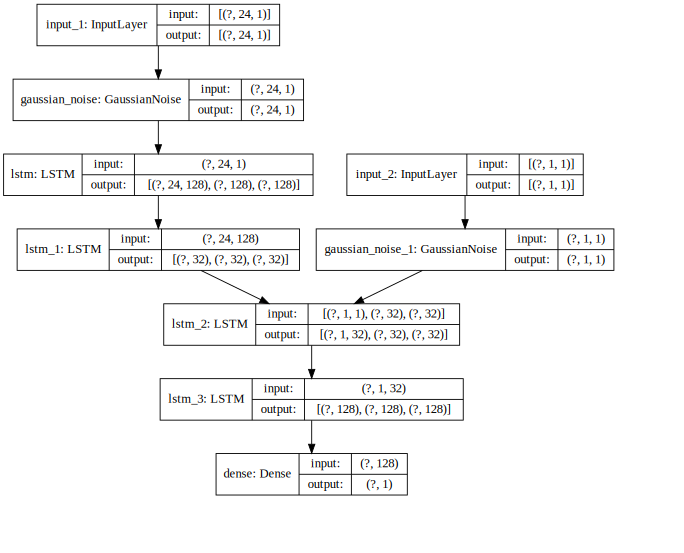

In [15]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(ae_model,show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

#### 编码器图解

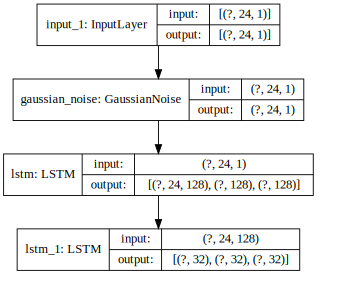

In [16]:
SVG(model_to_dot(encoder_model,show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

#### 预训练

In [17]:
#预训练

ae_history = ae_model.fit(
    [Y_encoder_train, Y_decoder_train],
    Y_label_train,
    batch_size=128,
    epochs=500,
    verbose=2,
    shuffle=True,
    validation_data=([Y_encoder_val,
                      Y_decoder_val], Y_label_val))

Epoch 1/500
29/29 - 1s - loss: 0.1055 - val_loss: 0.0796
Epoch 2/500
29/29 - 0s - loss: 0.0947 - val_loss: 0.0703
Epoch 3/500
29/29 - 0s - loss: 0.0877 - val_loss: 0.0707
Epoch 4/500
29/29 - 0s - loss: 0.0846 - val_loss: 0.0749
Epoch 5/500
29/29 - 0s - loss: 0.0852 - val_loss: 0.0675
Epoch 6/500
29/29 - 0s - loss: 0.0819 - val_loss: 0.0681
Epoch 7/500
29/29 - 0s - loss: 0.0800 - val_loss: 0.0629
Epoch 8/500
29/29 - 0s - loss: 0.0792 - val_loss: 0.0584
Epoch 9/500
29/29 - 0s - loss: 0.0806 - val_loss: 0.0625
Epoch 10/500
29/29 - 0s - loss: 0.0784 - val_loss: 0.0646
Epoch 11/500
29/29 - 0s - loss: 0.0773 - val_loss: 0.0633
Epoch 12/500
29/29 - 0s - loss: 0.0747 - val_loss: 0.0683
Epoch 13/500
29/29 - 0s - loss: 0.0744 - val_loss: 0.0592
Epoch 14/500
29/29 - 0s - loss: 0.0751 - val_loss: 0.0622
Epoch 15/500
29/29 - 0s - loss: 0.0723 - val_loss: 0.0628
Epoch 16/500
29/29 - 0s - loss: 0.0731 - val_loss: 0.0591
Epoch 17/500
29/29 - 0s - loss: 0.0717 - val_loss: 0.0508
Epoch 18/500
29/29 - 0s

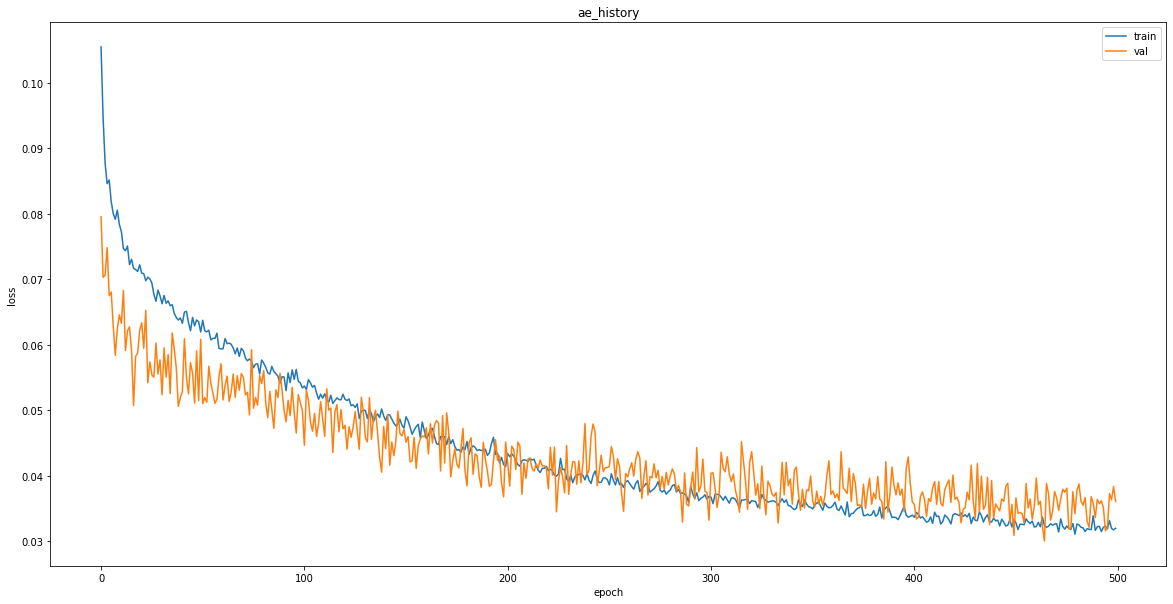

In [18]:
def plot_train_history(history, name):
    plt.figure(figsize = (20,10))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(name, fontsize='12')
    plt.ylabel('loss', fontsize='10')
    plt.xlabel('epoch', fontsize='10')
    plt.legend()
    plt.show()

plot_train_history(ae_history, 'ae_history')

In [19]:
# inference_feature
XX_train = encoder_model.predict(Y_encoder_train)
XX_val = encoder_model.predict(Y_encoder_val)
XX_test = encoder_model.predict(Y_encoder_test)

### 预测模型

In [20]:
X = Input(shape = (32,))
F = Input(shape = (10,))
    
temp = Concatenate(axis=1)([X,F])

dense1 = Dense(128,activation='tanh')
dense1_output = dense1(temp)
    
drop_out3 = Dropout(0.02)
dense1_output = drop_out3(dense1_output, training = True)
    
dense2 = Dense(64,activation='tanh')
dense2_output = dense2(dense1_output)
# dense2_output = dense2(temp)
    
drop_out4 = Dropout(0.05)
dense2_output = drop_out4(dense2_output, training = True)
    
dense3 = Dense(16,activation='tanh')
dense3_output = dense3(dense2_output)
    
drop_out5 = Dropout(0.05)
dense3_output = drop_out5(dense3_output, training = True)
    
dense4 = Dense(1,activation='tanh')
dense4_output = dense4(dense3_output)
    
forecast_model = Model(inputs=[X,F], outputs=dense4_output)
forecast_model.compile(loss='mae', optimizer='adam')

In [21]:
forecast_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 42)           0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          5504        concatenate[0][0]     

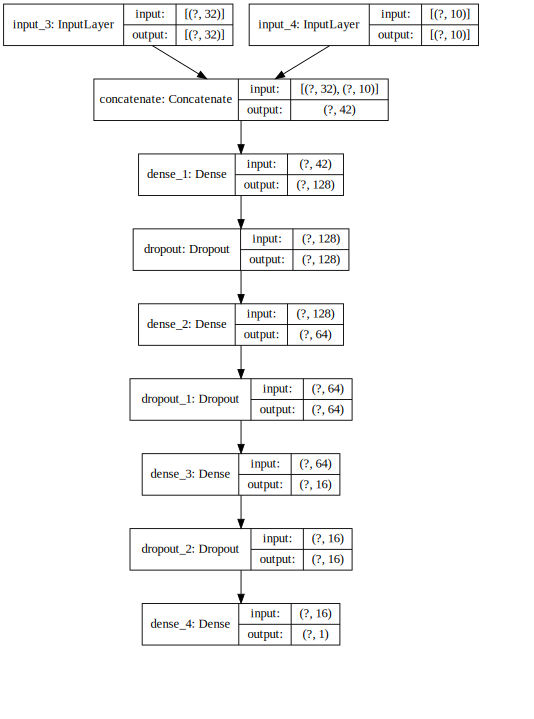

In [22]:
SVG(model_to_dot(forecast_model,show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [23]:
forecast_history = forecast_model.fit([XX_train, external_feature_train],
                                      Y_label_train,
                                      batch_size=128,
                                      epochs=500,
                                      verbose=2,
                                      shuffle=True,
                                      validation_data=([XX_val,external_feature_val],
                                                       Y_label_val))

Epoch 1/500
29/29 - 0s - loss: 0.1439 - val_loss: 0.1143
Epoch 2/500
29/29 - 0s - loss: 0.1048 - val_loss: 0.0857
Epoch 3/500
29/29 - 0s - loss: 0.0908 - val_loss: 0.0731
Epoch 4/500
29/29 - 0s - loss: 0.0769 - val_loss: 0.0754
Epoch 5/500
29/29 - 0s - loss: 0.0709 - val_loss: 0.0754
Epoch 6/500
29/29 - 0s - loss: 0.0668 - val_loss: 0.0566
Epoch 7/500
29/29 - 0s - loss: 0.0602 - val_loss: 0.0563
Epoch 8/500
29/29 - 0s - loss: 0.0569 - val_loss: 0.0531
Epoch 9/500
29/29 - 0s - loss: 0.0578 - val_loss: 0.0516
Epoch 10/500
29/29 - 0s - loss: 0.0529 - val_loss: 0.0509
Epoch 11/500
29/29 - 0s - loss: 0.0515 - val_loss: 0.0447
Epoch 12/500
29/29 - 0s - loss: 0.0500 - val_loss: 0.0468
Epoch 13/500
29/29 - 0s - loss: 0.0504 - val_loss: 0.0466
Epoch 14/500
29/29 - 0s - loss: 0.0491 - val_loss: 0.0458
Epoch 15/500
29/29 - 0s - loss: 0.0484 - val_loss: 0.0472
Epoch 16/500
29/29 - 0s - loss: 0.0482 - val_loss: 0.0438
Epoch 17/500
29/29 - 0s - loss: 0.0475 - val_loss: 0.0472
Epoch 18/500
29/29 - 0s

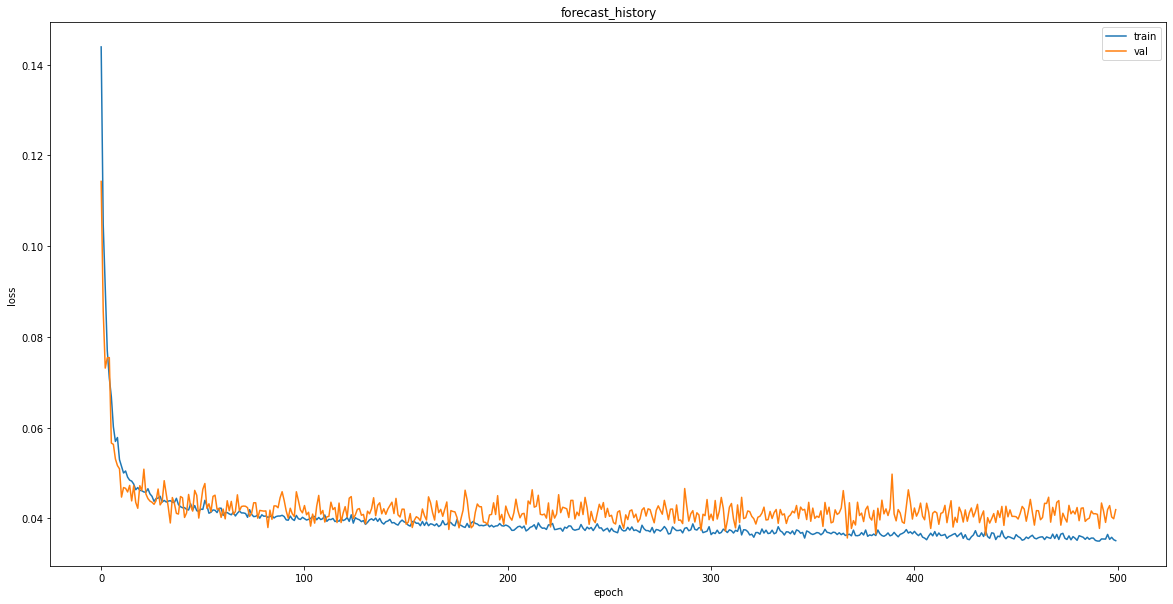

In [24]:
plot_train_history(forecast_history, 'forecast_history')

### 结果评估

#### 训练集

In [25]:
Y_train_predict = forecast_model.predict([XX_train, external_feature_train]) 
Y_train_predict = Y_train_predict.reshape(len(Y_train_predict),)
Y_train_predict = Y_train_predict + Y_start_train
Y_train_predict = 10**(Y_train_predict)-100
Y_train_predict

array([1693.37343933, 1010.69593071, 1005.27691842, ..., 5655.23054815,
       4122.49821992, 3969.54505452])

In [26]:
Y_label_train = Y_label_train + Y_start_train
Y_label_train = 10**(Y_label_train) - 100
Y_label_train

array([1071.,  550.,  389., ..., 4542., 4099., 2444.])

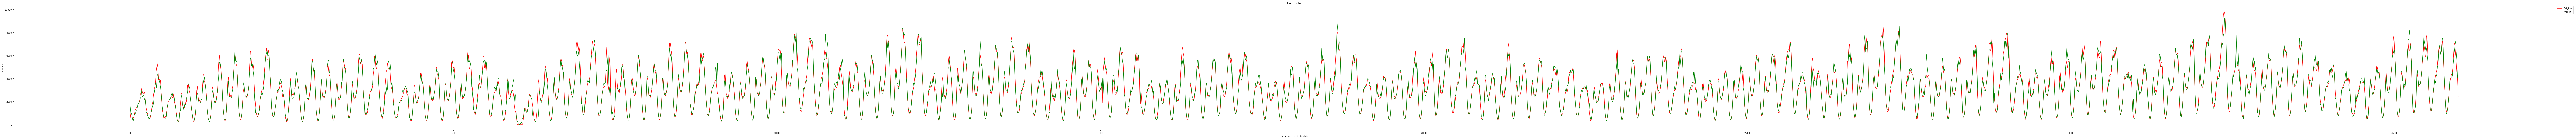

In [27]:
plt.figure(figsize = (200,10))
plt.plot(Y_label_train,color='red',label='Original')
plt.plot(Y_train_predict,color='green',label='Predict')
plt.xlabel('the number of train data')
plt.ylabel('number')
plt.title('train_data')
plt.legend()
plt.show()

In [28]:
mse = mean_squared_error(Y_train_predict,Y_label_train)
# calculate RMSE 均方根误差
rmse = sqrt(mean_squared_error(Y_train_predict,Y_label_train))
#calculate MAE 平均绝对误差
mae = mean_absolute_error(Y_train_predict,Y_label_train)
#calculate R square
r_square = r2_score(Y_train_predict,Y_label_train)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)
print('R_square: %.6f' % r_square)

均方误差: 149413.326385
均方根误差: 386.540200
平均绝对误差: 238.464224
R_square: 0.951368


#### 验证集

In [29]:
# Y_val_predict = forecast_model.predict([XX_val, external_feature_val])
# Y_val_predict = Y_val_predict.reshape(len(Y_val_predict),1,1)
# Y_temp = np.concatenate((Y_val_predict,Y_encoder_val),axis = 1).reshape(len(Y_val_predict),tp+1)
# Y_temp = Y_scaler.inverse_transform(Y_temp)

# Y_val_predict = Y_temp[:,0]

In [30]:
# Y_label_val = Y_label_val.reshape(len(Y_label_val),1,1)
# Y_temp = np.concatenate((Y_label_val,Y_encoder_val),axis = 1).reshape(len(Y_label_val),tp+1)
# Y_temp = Y_scaler.inverse_transform(Y_temp)

# Y_label_val = Y_temp[:,0]

In [31]:
Y_val_predict = forecast_model.predict([XX_val, external_feature_val]) 
Y_val_predict = Y_val_predict.reshape(len(Y_val_predict),)
Y_val_predict = Y_val_predict + Y_start_val
Y_val_predict = 10**(Y_val_predict)-100
Y_val_predict

array([1674.59582426,  783.60846113,  682.88954201,  628.90046161,
       1134.17984337, 1792.46230492, 2550.14832843, 4894.85010216,
       5611.30089454, 5125.66266605, 3965.57389255, 3672.63579527,
       4709.10323671, 4373.67554698, 4268.01485369, 3959.74920393,
       4529.70827866, 5632.85086239, 4491.93268649, 6818.66245791,
       6508.52426501, 5462.42768987, 4884.59049874, 3624.02886958,
       2241.18473225, 1354.48556442,  777.51780433,  719.26685562,
       1084.77623788, 1715.99413726, 3006.57914233, 4380.22957331,
       5349.59741763, 4643.75016539, 3275.68125203, 3406.25229025,
       3279.27337652, 3495.71299833, 3921.00670901, 4597.05770817,
       5761.76363256, 7191.68188837, 7653.82670971, 7779.41672881,
       6747.33108201, 6795.82878079, 6358.95034768, 3934.85913451,
       2546.49759767, 1160.10814746,  660.41665705,  723.89586549,
        926.37365279, 1626.09799149, 3091.71623483, 4618.93790591,
       5893.02212582, 4141.32155498, 3594.47047306, 3095.09979

In [32]:
Y_label_val = Y_label_val + Y_start_val
Y_label_val = 10**(Y_label_val) - 100
Y_label_val

array([1748., 1309.,  722.,  759., 1266., 1819., 2962., 4390., 5131.,
       4357., 4954., 4830., 4051., 3578., 3941., 4226., 4899., 5680.,
       6811., 6383., 6127., 5846., 5020., 3151., 1902., 1173.,  601.,
        557.,  988., 1566., 2910., 4688., 5362., 4417., 3428., 3398.,
       3280., 3539., 4676., 5109., 5675., 6675., 7834., 7124., 6913.,
       6825., 5570., 3565., 1955.,  993.,  610.,  586.,  946., 1505.,
       2773., 4004., 4409., 3719., 3072., 3077., 2899., 3202., 3519.,
       4005., 4748., 5598., 6543., 5997., 6280., 6731., 6018., 4446.,
       2478., 1250.,  791.,  720., 1040., 1605., 2709., 4062., 3885.,
       3539., 3157., 3346., 3116., 3386., 3899., 4545., 5234., 6380.,
       7165., 6593., 6919., 7324., 6833., 5860., 3186., 1800., 1169.,
       1021., 1180., 1601., 2681., 3988., 4596., 4329., 4469., 4510.,
       4386., 4391., 4511., 4720., 5310., 5891., 6517., 6020., 5872.,
       6086., 7175., 7365., 5917., 3797., 2660., 1939., 1584., 1362.,
       1593., 1980.,

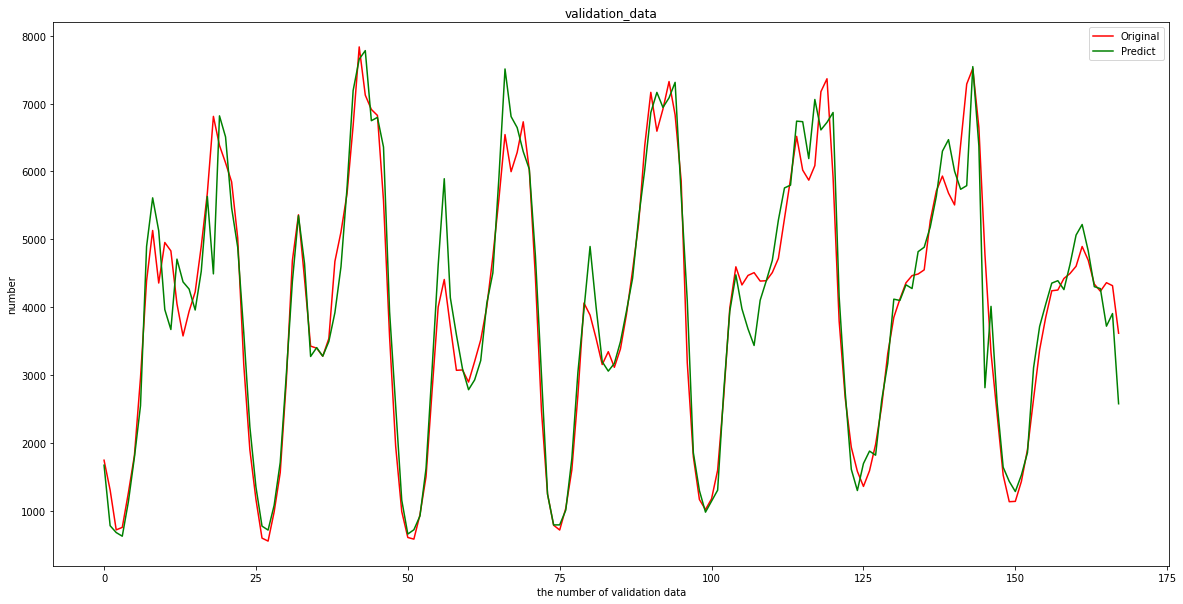

In [33]:
plt.figure(figsize = (20,10))
plt.plot(Y_label_val,color='red',label='Original')
plt.plot(Y_val_predict,color='green',label='Predict')
plt.xlabel('the number of validation data')
plt.ylabel('number')
plt.title('validation_data')
plt.legend()
plt.show()

In [34]:
mse = mean_squared_error(Y_val_predict,Y_label_val)
# calculate RMSE 均方根误差
rmse = sqrt(mean_squared_error(Y_val_predict,Y_label_val))
#calculate MAE 平均绝对误差
mae = mean_absolute_error(Y_val_predict,Y_label_val)
#calculate R square
r_square = r2_score(Y_val_predict,Y_label_val)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)
print('R_square: %.6f' % r_square)

均方误差: 244091.712367
均方根误差: 494.056386
平均绝对误差: 343.261002
R_square: 0.932642


#### 测试集

In [35]:
# Y_test_predict = forecast_model.predict([XX_test, external_feature_test])
# Y_test_predict = Y_test_predict.reshape(len(Y_test_predict),1,1)
# Y_temp = np.concatenate((Y_test_predict,Y_encoder_test),axis = 1).reshape(len(Y_test_predict),tp+1)
# Y_temp = Y_scaler.inverse_transform(Y_temp)

# Y_test_predict = Y_temp[:,0]

# Y_label_test = Y_label_test.reshape(len(Y_label_test),1,1)
# Y_temp = np.concatenate((Y_label_test,Y_encoder_test),axis = 1).reshape(len(Y_label_test),tp+1)
# Y_temp = Y_scaler.inverse_transform(Y_temp)

# Y_label_test = Y_temp[:,0]

In [36]:
Y_test_predict = forecast_model.predict([XX_test, external_feature_test]) 
Y_test_predict = Y_test_predict.reshape(len(Y_test_predict),)
Y_test_predict = Y_test_predict + Y_start_test
Y_test_predict = 10**(Y_test_predict)-100
Y_test_predict

array([ 1499.06531302,   927.73145313,   689.34689719,   568.95636568,
        1271.66354222,  1673.10073728,  2675.84465688,  3195.28512265,
        4898.51449028,  3281.88518163,  3122.35386682,  2921.69607931,
        2847.39995935,  2956.64358669,  2976.08089116,  3717.87666246,
        3882.81142979,  5049.53338774,  5367.63159224,  5168.45606226,
        4762.875395  ,  4716.61330125,  4464.81047554,  3633.8446471 ,
        2019.31350977,  1042.25329011,   677.54449453,   683.23619224,
         725.71774146,  1735.26559186,  2682.49932831,  4121.31813758,
        4465.04002972,  3665.86228919,  3055.24472144,  3050.59785977,
        2919.45350656,  2999.25462734,  3451.42669925,  3764.52246307,
        4688.04910715,  5873.88337655,  5871.83139243,  5523.46947341,
        5528.03859603,  5830.39832741,  5297.32773312,  3157.14969951,
        2168.39381806,  1467.79465673,   618.35023101,   523.80615822,
        1070.27611135,  1181.78993086,  2714.86144188,  4620.62588361,
      

In [37]:
Y_label_test = Y_label_test + Y_start_test
Y_label_test = 10**(Y_label_test) - 100
Y_label_test

array([ 1872.,   975.,   672.,   701.,  1193.,  1827.,  2716.,  3938.,
        4329.,  3848.,  3169.,  3040.,  2916.,  2987.,  3335.,  3574.,
        3912.,  4703.,  5021.,  4383.,  4727.,  5353.,  4438.,  3089.,
        1742.,   866.,   524.,   540.,   956.,  1477.,  2687.,  4342.,
        4749.,  3968.,  3186.,  3194.,  3084.,  3325.,  3583.,  4079.,
        4676.,  5458.,  5843.,  5059.,  5491.,  5658.,  4671.,  3769.,
        1865.,  1022.,   637.,   637.,   966.,  1588.,  2687.,  4032.,
        4526.,  3900.,  3237.,  3220.,  3189.,  3455.,  3866.,  4340.,
        4857.,  5719.,  6402.,  5577.,  5816.,  6129.,  5674.,  3913.,
        2214.,  1178.,   745.,   638.,   999.,  1666.,  2819.,  4172.,
        4783.,  4140.,  3537.,  3730.,  3671.,  3938.,  4393.,  5021.,
        5676.,  6766.,  7639.,  7092.,  7180.,  7863.,  7187.,  6195.,
        3278.,  1853.,  1102.,  1028.,  1354.,  1828.,  2755.,  4112.,
        4610.,  4108.,  3749.,  3639.,  3668.,  3969.,  4392.,  4972.,
      

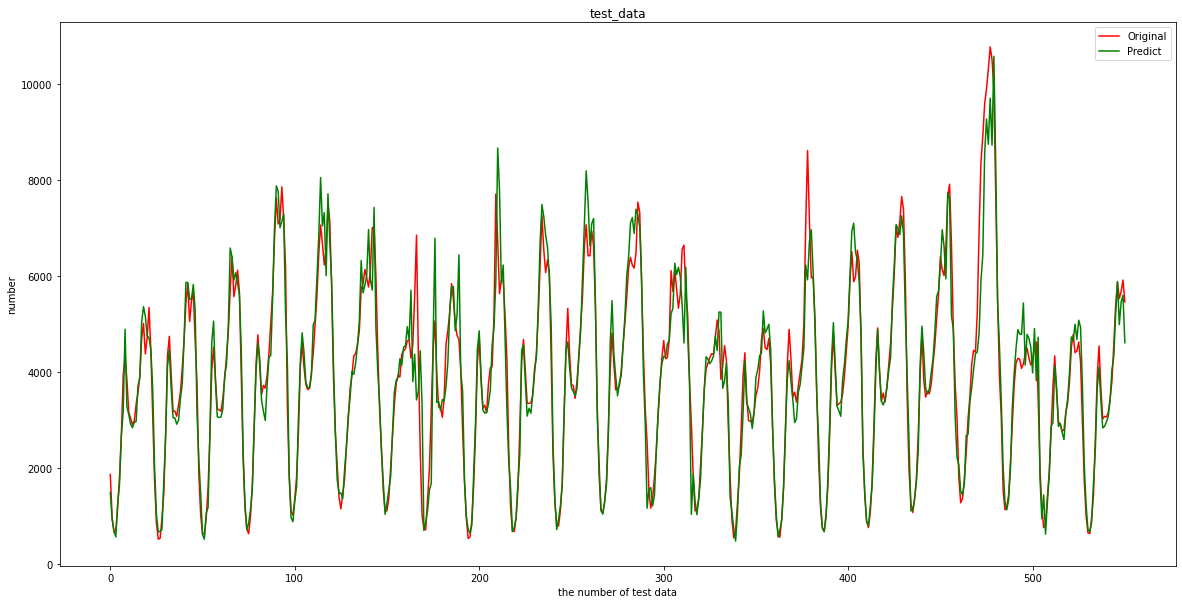

In [38]:
plt.figure(figsize = (20,10))
plt.plot(Y_label_test,color='red',label='Original')
plt.plot(Y_test_predict,color='green',label='Predict')
plt.xlabel('the number of test data')
plt.ylabel('number')
plt.title('test_data')
plt.legend()
plt.show()

In [39]:
mse = mean_squared_error(Y_test_predict,Y_label_test)
# calculate RMSE 均方根误差
rmse = sqrt(mean_squared_error(Y_test_predict,Y_label_test))
#calculate MAE 平均绝对误差
mae = mean_absolute_error(Y_test_predict,Y_label_test)
#calculate R square
r_square = r2_score(Y_test_predict,Y_label_test)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)
print('R_square: %.6f' % r_square)

均方误差: 301146.320600
均方根误差: 548.768003
平均绝对误差: 345.721454
R_square: 0.918474
